# Method 9 - Best Ideas High Minus Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
low_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

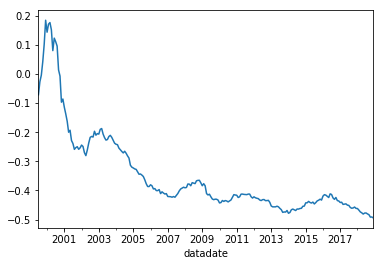

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.184313
2000-12-31   -0.228315
2001-12-31   -0.183322
2002-12-31    0.065497
2003-12-31   -0.041466
2004-12-31   -0.107871
2005-12-31   -0.097837
2006-12-31   -0.039470
2007-12-31    0.037272
2008-12-31    0.024512
2009-12-31   -0.094515
2010-12-31    0.030768
2011-12-31   -0.017905
2012-12-31   -0.025554
2013-12-31   -0.050056
2014-12-31    0.028144
2015-12-31    0.037970
2016-12-31   -0.005341
2017-12-31   -0.045181
2018-12-31   -0.060684
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     7.320
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.45e-05
Time:                        20:59:57   Log-Likelihood:                 626.91
No. Observations:                 234   AIC:                            -1244.
Df Residuals:                     229   BIC:                            -1227.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.001     -2.378      0.018      -0.005      -0.000
mktrf          0.0450      0.031      1.438      0.152      -0.017       0.107
me            -0.0217      0.036     -0.597      0.551      -0.093       0.050
ia            -0.2704      0.055     -4.886      0.000      -0.379      -0.161
roe            0.1146      0.047      2.420      0.016       0.021       0.208
==============================================================================
Omnibus:                       34.868   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.463
Skew:                          -0.340   Prob(JB):                     9.78e-43
Kurtosis:                       7.402   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     5.580
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000265
Time:                        20:59:57   Log-Likelihood:                 626.91
No. Observations:                 234   AIC:                            -1244.
Df Residuals:                     229   BIC:                            -1227.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.798      0.072      -0.006       0.000
mktrf          0.0450      0.032      1.413      0.158      -0.017       0.107
me            -0.0217      0.050     -0.438      0.661      -0.119       0.076
ia            -0.2704      0.121     -2.240      0.025      -0.507      -0.034
roe            0.1146      0.041      2.796      0.005       0.034       0.195
==============================================================================
Omnibus:                       34.868   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.463
Skew:                          -0.340   Prob(JB):                     9.78e-43
Kurtosis:                       7.402   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     7.402
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-05
Time:                        20:59:57   Log-Likelihood:                 626.91
No. Observations:                 234   AIC:                            -1244.
Df Residuals:                     229   BIC:                            -1227.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.794      0.073      -0.006       0.000
mktrf          0.0450      0.036      1.258      0.208      -0.025       0.115
me            -0.0217      0.042     -0.514      0.607      -0.105       0.061
ia            -0.2704      0.136     -1.983      0.047      -0.538      -0.003
roe            0.1146      0.036      3.193      0.001       0.044       0.185
==============================================================================
Omnibus:                       34.868   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.463
Skew:                          -0.340   Prob(JB):                     9.78e-43
Kurtosis:                       7.402   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     7.943
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.42e-07
Time:                        20:59:57   Log-Likelihood:                 631.62
No. Observations:                 234   AIC:                            -1251.
Df Residuals:                     228   BIC:                            -1231.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.694      0.092      -0.004       0.000
mktrf          0.0077      0.031      0.251      0.802      -0.053       0.068
smb           -0.0604      0.041     -1.487      0.139      -0.141       0.020
hml           -0.1526      0.048     -3.183      0.002      -0.247      -0.058
rmw           -0.0292      0.054     -0.538      0.591      -0.136       0.078
cma           -0.0870      0.069     -1.263      0.208      -0.223       0.049
==============================================================================
Omnibus:                       33.318   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.831
Skew:                          -0.441   Prob(JB):                     1.18e-30
Kurtosis:                       6.655   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     5.023
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000219
Time:                        20:59:57   Log-Likelihood:                 631.62
No. Observations:                 234   AIC:                            -1251.
Df Residuals:                     228   BIC:                            -1231.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.513      0.130      -0.004       0.001
mktrf          0.0077      0.033      0.238      0.812      -0.056       0.072
smb           -0.0604      0.044     -1.364      0.172      -0.147       0.026
hml           -0.1526      0.058     -2.642      0.008      -0.266      -0.039
rmw           -0.0292      0.061     -0.478      0.632      -0.149       0.090
cma           -0.0870      0.090     -0.968      0.333      -0.263       0.089
==============================================================================
Omnibus:                       33.318   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.831
Skew:                          -0.441   Prob(JB):                     1.18e-30
Kurtosis:                       6.655   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     5.639
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.36e-05
Time:                        20:59:57   Log-Likelihood:                 631.62
No. Observations:                 234   AIC:                            -1251.
Df Residuals:                     228   BIC:                            -1231.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.525      0.127      -0.004       0.001
mktrf          0.0077      0.036      0.217      0.828      -0.062       0.078
smb           -0.0604      0.031     -1.925      0.054      -0.122       0.001
hml           -0.1526      0.055     -2.800      0.005      -0.259      -0.046
rmw           -0.0292      0.060     -0.484      0.628      -0.147       0.089
cma           -0.0870      0.089     -0.973      0.331      -0.262       0.088
==============================================================================
Omnibus:                       33.318   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.831
Skew:                          -0.441   Prob(JB):                     1.18e-30
Kurtosis:                       6.655   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     18.07
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.50e-13
Time:                        20:59:57   Log-Likelihood:                 644.93
No. Observations:                 234   AIC:                            -1280.
Df Residuals:                     229   BIC:                            -1263.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.001     -2.993      0.003      -0.005      -0.001
mktrf          0.0854      0.027      3.199      0.002       0.033       0.138
smb           -0.0825      0.033     -2.475      0.014      -0.148      -0.017
hml           -0.1776      0.033     -5.368      0.000      -0.243      -0.112
umd            0.1211      0.022      5.576      0.000       0.078       0.164
==============================================================================
Omnibus:                       42.059   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.219
Skew:                          -0.641   Prob(JB):                     8.06e-37
Kurtosis:                       6.925   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     7.544
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-05
Time:                        20:59:57   Log-Likelihood:                 644.93
No. Observations:                 234   AIC:                            -1280.
Df Residuals:                     229   BIC:                            -1263.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.001     -2.362      0.018      -0.006      -0.001
mktrf          0.0854      0.048      1.771      0.077      -0.009       0.180
smb           -0.0825      0.032     -2.577      0.010      -0.145      -0.020
hml           -0.1776      0.059     -3.009      0.003      -0.293      -0.062
umd            0.1211      0.032      3.760      0.000       0.058       0.184
==============================================================================
Omnibus:                       42.059   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.219
Skew:                          -0.641   Prob(JB):                     8.06e-37
Kurtosis:                       6.925   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     7.126
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.01e-05
Time:                        20:59:57   Log-Likelihood:                 644.93
No. Observations:                 234   AIC:                            -1280.
Df Residuals:                     229   BIC:                            -1263.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.001     -2.239      0.025      -0.006      -0.000
mktrf          0.0854      0.057      1.492      0.136      -0.027       0.198
smb           -0.0825      0.029     -2.825      0.005      -0.140      -0.025
hml           -0.1776      0.068     -2.596      0.009      -0.312      -0.044
umd            0.1211      0.036      3.388      0.001       0.051       0.191
==============================================================================
Omnibus:                       42.059   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.219
Skew:                          -0.641   Prob(JB):                     8.06e-37
Kurtosis:                       6.925   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     5.071
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000845
Time:                        20:59:57   Log-Likelihood:                 292.61
No. Observations:                 120   AIC:                            -575.2
Df Residuals:                     115   BIC:                            -561.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.002     -1.649      0.102      -0.007       0.001
mktrf          0.0430      0.056      0.774      0.441      -0.067       0.153
me            -0.0113      0.055     -0.207      0.837      -0.120       0.097
ia            -0.3658      0.086     -4.253      0.000      -0.536      -0.195
roe            0.1254      0.076      1.647      0.102      -0.025       0.276
==============================================================================
Omnibus:                        8.964   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               15.826
Skew:                          -0.254   Prob(JB):                     0.000366
Kurtosis:                       4.705   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     3.171
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0164
Time:                        20:59:57   Log-Likelihood:                 292.61
No. Observations:                 120   AIC:                            -575.2
Df Residuals:                     115   BIC:                            -561.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -1.198      0.231      -0.009       0.002
mktrf          0.0430      0.060      0.720      0.471      -0.074       0.160
me            -0.0113      0.061     -0.186      0.852      -0.131       0.108
ia            -0.3658      0.154     -2.381      0.017      -0.667      -0.065
roe            0.1254      0.064      1.954      0.051      -0.000       0.251
==============================================================================
Omnibus:                        8.964   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               15.826
Skew:                          -0.254   Prob(JB):                     0.000366
Kurtosis:                       4.705   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     3.472
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0102
Time:                        20:59:57   Log-Likelihood:                 292.61
No. Observations:                 120   AIC:                            -575.2
Df Residuals:                     115   BIC:                            -561.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -1.216      0.224      -0.009       0.002
mktrf          0.0430      0.067      0.640      0.522      -0.089       0.175
me            -0.0113      0.056     -0.203      0.839      -0.121       0.098
ia            -0.3658      0.168     -2.184      0.029      -0.694      -0.037
roe            0.1254      0.058      2.145      0.032       0.011       0.240
==============================================================================
Omnibus:                        8.964   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               15.826
Skew:                          -0.254   Prob(JB):                     0.000366
Kurtosis:                       4.705   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     5.567
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000126
Time:                        20:59:57   Log-Likelihood:                 295.98
No. Observations:                 120   AIC:                            -580.0
Df Residuals:                     114   BIC:                            -563.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.897      0.371      -0.006       0.002
mktrf         -0.0338      0.057     -0.590      0.556      -0.147       0.080
smb           -0.0820      0.065     -1.264      0.209      -0.211       0.046
hml           -0.1503      0.079     -1.891      0.061      -0.308       0.007
rmw           -0.0784      0.094     -0.836      0.405      -0.264       0.107
cma           -0.1589      0.103     -1.547      0.125      -0.362       0.045
==============================================================================
Omnibus:                       10.047   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               15.247
Skew:                          -0.391   Prob(JB):                     0.000489
Kurtosis:                       4.562   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     8.123
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.38e-06
Time:                        20:59:57   Log-Likelihood:                 295.98
No. Observations:                 120   AIC:                            -580.0
Df Residuals:                     114   BIC:                            -563.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.808      0.419      -0.006       0.003
mktrf         -0.0338      0.061     -0.553      0.581      -0.154       0.086
smb           -0.0820      0.061     -1.341      0.180      -0.202       0.038
hml           -0.1503      0.105     -1.429      0.153      -0.357       0.056
rmw           -0.0784      0.101     -0.773      0.440      -0.277       0.120
cma           -0.1589      0.118     -1.346      0.178      -0.390       0.073
==============================================================================
Omnibus:                       10.047   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               15.247
Skew:                          -0.391   Prob(JB):                     0.000489
Kurtosis:                       4.562   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     13.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.05e-10
Time:                        20:59:57   Log-Likelihood:                 295.98
No. Observations:                 120   AIC:                            -580.0
Df Residuals:                     114   BIC:                            -563.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.841      0.400      -0.006       0.002
mktrf         -0.0338      0.063     -0.533      0.594      -0.158       0.090
smb           -0.0820      0.041     -1.995      0.046      -0.163      -0.001
hml           -0.1503      0.101     -1.495      0.135      -0.347       0.047
rmw           -0.0784      0.087     -0.904      0.366      -0.248       0.092
cma           -0.1589      0.122     -1.306      0.192      -0.397       0.080
==============================================================================
Omnibus:                       10.047   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               15.247
Skew:                          -0.391   Prob(JB):                     0.000489
Kurtosis:                       4.562   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     14.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-09
Time:                        20:59:57   Log-Likelihood:                 307.46
No. Observations:                 120   AIC:                            -604.9
Df Residuals:                     115   BIC:                            -591.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.002     -1.829      0.070      -0.007       0.000
mktrf          0.1311      0.043      3.029      0.003       0.045       0.217
smb           -0.1250      0.049     -2.536      0.013      -0.223      -0.027
hml           -0.2318      0.049     -4.696      0.000      -0.330      -0.134
umd            0.1623      0.030      5.331      0.000       0.102       0.223
==============================================================================
Omnibus:                       14.155   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.682
Skew:                          -0.530   Prob(JB):                     7.20e-06
Kurtosis:                       4.900   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     7.856
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-05
Time:                        20:59:57   Log-Likelihood:                 307.46
No. Observations:                 120   AIC:                            -604.9
Df Residuals:                     115   BIC:                            -591.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.002     -1.596      0.110      -0.007       0.001
mktrf          0.1311      0.065      2.010      0.044       0.003       0.259
smb           -0.1250      0.046     -2.722      0.006      -0.215      -0.035
hml           -0.2318      0.073     -3.174      0.002      -0.375      -0.089
umd            0.1623      0.039      4.135      0.000       0.085       0.239
==============================================================================
Omnibus:                       14.155   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.682
Skew:                          -0.530   Prob(JB):                     7.20e-06
Kurtosis:                       4.900   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     8.756
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.31e-06
Time:                        20:59:57   Log-Likelihood:                 307.46
No. Observations:                 120   AIC:                            -604.9
Df Residuals:                     115   BIC:                            -591.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.002     -1.617      0.106      -0.007       0.001
mktrf          0.1311      0.075      1.760      0.078      -0.015       0.277
smb           -0.1250      0.048     -2.608      0.009      -0.219      -0.031
hml           -0.2318      0.082     -2.835      0.005      -0.392      -0.072
umd            0.1623      0.044      3.701      0.000       0.076       0.248
==============================================================================
Omnibus:                       14.155   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.682
Skew:                          -0.530   Prob(JB):                     7.20e-06
Kurtosis:                       4.900   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     5.503
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000450
Time:                        20:59:57   Log-Likelihood:                 385.37
No. Observations:                 114   AIC:                            -760.7
Df Residuals:                     109   BIC:                            -747.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -2.306      0.023      -0.004      -0.000
mktrf          0.0275      0.025      1.111      0.269      -0.022       0.077
me            -0.0212      0.038     -0.553      0.581      -0.097       0.055
ia             0.0192      0.053      0.362      0.718      -0.086       0.124
roe            0.1998      0.047      4.289      0.000       0.108       0.292
==============================================================================
Omnibus:                        2.794   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.214
Skew:                           0.302   Prob(JB):                        0.331
Kurtosis:                       3.318   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     9.701
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.48e-07
Time:                        20:59:57   Log-Likelihood:                 385.37
No. Observations:                 114   AIC:                            -760.7
Df Residuals:                     109   BIC:                            -747.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.658      0.097      -0.004       0.000
mktrf          0.0275      0.028      0.994      0.320      -0.027       0.082
me            -0.0212      0.039     -0.536      0.592      -0.098       0.056
ia             0.0192      0.065      0.294      0.769      -0.109       0.147
roe            0.1998      0.038      5.225      0.000       0.125       0.275
==============================================================================
Omnibus:                        2.794   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.214
Skew:                           0.302   Prob(JB):                        0.331
Kurtosis:                       3.318   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     12.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.00e-08
Time:                        20:59:57   Log-Likelihood:                 385.37
No. Observations:                 114   AIC:                            -760.7
Df Residuals:                     109   BIC:                            -747.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.440      0.150      -0.005       0.001
mktrf          0.0275      0.028      0.966      0.334      -0.028       0.083
me            -0.0212      0.037     -0.568      0.570      -0.094       0.052
ia             0.0192      0.067      0.288      0.774      -0.112       0.150
roe            0.1998      0.038      5.240      0.000       0.125       0.275
==============================================================================
Omnibus:                        2.794   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.214
Skew:                           0.302   Prob(JB):                        0.331
Kurtosis:                       3.318   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     5.465
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000160
Time:                        20:59:57   Log-Likelihood:                 387.74
No. Observations:                 114   AIC:                            -763.5
Df Residuals:                     108   BIC:                            -747.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -2.305      0.023      -0.004      -0.000
mktrf          0.0245      0.023      1.055      0.294      -0.022       0.071
smb           -0.0109      0.038     -0.289      0.773      -0.086       0.064
hml           -0.0476      0.048     -0.990      0.324      -0.143       0.048
rmw            0.2539      0.059      4.311      0.000       0.137       0.371
cma            0.0500      0.075      0.669      0.505      -0.098       0.198
==============================================================================
Omnibus:                        1.032   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.597   Jarque-Bera (JB):                0.995
Skew:                           0.222   Prob(JB):                        0.608
Kurtosis:                       2.892   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     12.02
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.92e-09
Time:                        20:59:57   Log-Likelihood:                 387.74
No. Observations:                 114   AIC:                            -763.5
Df Residuals:                     108   BIC:                            -747.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.717      0.086      -0.004       0.000
mktrf          0.0245      0.028      0.882      0.378      -0.030       0.079
smb           -0.0109      0.044     -0.250      0.803      -0.096       0.075
hml           -0.0476      0.057     -0.830      0.407      -0.160       0.065
rmw            0.2539      0.047      5.346      0.000       0.161       0.347
cma            0.0500      0.101      0.494      0.622      -0.149       0.249
==============================================================================
Omnibus:                        1.032   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.597   Jarque-Bera (JB):                0.995
Skew:                           0.222   Prob(JB):                        0.608
Kurtosis:                       2.892   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     19.52
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.27e-14
Time:                        20:59:57   Log-Likelihood:                 387.74
No. Observations:                 114   AIC:                            -763.5
Df Residuals:                     108   BIC:                            -747.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.513      0.130      -0.004       0.001
mktrf          0.0245      0.031      0.796      0.426      -0.036       0.085
smb           -0.0109      0.041     -0.268      0.788      -0.091       0.069
hml           -0.0476      0.052     -0.916      0.360      -0.149       0.054
rmw            0.2539      0.050      5.062      0.000       0.156       0.352
cma            0.0500      0.098      0.509      0.611      -0.143       0.243
==============================================================================
Omnibus:                        1.032   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.597   Jarque-Bera (JB):                0.995
Skew:                           0.222   Prob(JB):                        0.608
Kurtosis:                       2.892   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.528
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.199
Time:                        20:59:57   Log-Likelihood:                 378.00
No. Observations:                 114   AIC:                            -746.0
Df Residuals:                     109   BIC:                            -732.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.538      0.127      -0.003       0.000
mktrf          0.0062      0.025      0.249      0.804      -0.043       0.056
smb           -0.0664      0.039     -1.701      0.092      -0.144       0.011
hml           -0.0485      0.040     -1.205      0.231      -0.128       0.031
umd            0.0134      0.030      0.444      0.658      -0.047       0.074
==============================================================================
Omnibus:                        2.738   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.242
Skew:                           0.329   Prob(JB):                        0.326
Kurtosis:                       3.197   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.777
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.139
Time:                        20:59:57   Log-Likelihood:                 378.00
No. Observations:                 114   AIC:                            -746.0
Df Residuals:                     109   BIC:                            -732.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.120      0.263      -0.004       0.001
mktrf          0.0062      0.032      0.193      0.847      -0.057       0.069
smb           -0.0664      0.050     -1.336      0.181      -0.164       0.031
hml           -0.0485      0.048     -1.004      0.315      -0.143       0.046
umd            0.0134      0.039      0.347      0.729      -0.063       0.090
==============================================================================
Omnibus:                        2.738   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.242
Skew:                           0.329   Prob(JB):                        0.326
Kurtosis:                       3.197   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     4.240
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00315
Time:                        20:59:57   Log-Likelihood:                 378.00
No. Observations:                 114   AIC:                            -746.0
Df Residuals:                     109   BIC:                            -732.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -0.983      0.326      -0.004       0.001
mktrf          0.0062      0.035      0.179      0.858      -0.062       0.074
smb           -0.0664      0.047     -1.420      0.156      -0.158       0.025
hml           -0.0485      0.045     -1.080      0.280      -0.136       0.040
umd            0.0134      0.039      0.343      0.732      -0.063       0.090
==============================================================================
Omnibus:                        2.738   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.242
Skew:                           0.329   Prob(JB):                        0.326
Kurtosis:                       3.197   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""